In [1]:
import os
import torch 
import torchvision 
from torch.utils.data import random_split 
import torchvision.models as models 
import torch.nn as nn 
import torch.nn.functional as F
import joblib 

In [2]:
data_dir = './raw7data/'

classes = os.listdir(data_dir)
print(classes)

['kitchen', 'corridor', 'livingroom', 'dining_room', 'bedroom', 'office', 'bathroom']


In [3]:
len(classes)

7

In [4]:
from torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms 

transformations = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)


In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline 

def show_sample(img, label):
    print("label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(img.permute(1,2,0))


label: corridor (Class No: 2)


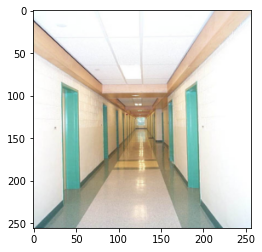

In [6]:
img, label = dataset[1000]
show_sample(img,label)

In [7]:
random_seed = 21 
torch.manual_seed(random_seed) 

In [8]:
len(dataset)

3028

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [2400,400,228])
len(train_ds),len(val_ds), len(test_ds)

(2400, 400, 228)

In [10]:
from torch.utils.data.dataloader import DataLoader 
batch_size = 12 

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)


In [12]:
# visualize batches
from torchvision.utils import make_grid 

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow = 16).permute(1,2,0))
        break;


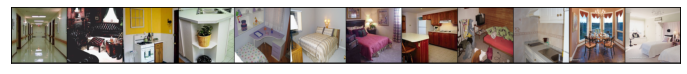

In [13]:
show_batch(train_dl)

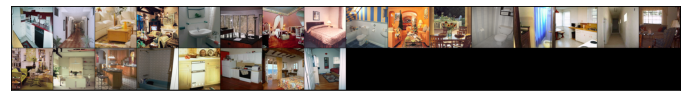

In [14]:
show_batch(val_dl)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:

device = get_default_device()
device 

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_dl)

{'val_loss': 1.974696397781372, 'val_acc': 0.1299019604921341}

In [26]:
num_epochs = 36
opt_func = torch.optim.Adam
lr = 6e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch 1: train_loss: 1.1745, val_loss: 1.2814, val_acc: 0.8775
Epoch 2: train_loss: 1.1714, val_loss: 1.2936, val_acc: 0.8664
Epoch 3: train_loss: 1.1713, val_loss: 1.2881, val_acc: 0.8701
Epoch 4: train_loss: 1.1722, val_loss: 1.2766, val_acc: 0.8983
Epoch 5: train_loss: 1.1701, val_loss: 1.2826, val_acc: 0.8799
Epoch 6: train_loss: 1.1721, val_loss: 1.2843, val_acc: 0.8640
Epoch 7: train_loss: 1.1702, val_loss: 1.2967, val_acc: 0.8689
Epoch 8: train_loss: 1.1699, val_loss: 1.2956, val_acc: 0.8542
Epoch 9: train_loss: 1.1691, val_loss: 1.2835, val_acc: 0.8738
Epoch 10: train_loss: 1.1705, val_loss: 1.2787, val_acc: 0.8824
Epoch 11: train_loss: 1.1688, val_loss: 1.2830, val_acc: 0.8725
Epoch 12: train_loss: 1.1695, val_loss: 1.2876, val_acc: 0.8640
Epoch 13: train_loss: 1.1694, val_loss: 1.2931, val_acc: 0.8615
Epoch 14: train_loss: 1.1707, val_loss: 1.2838, val_acc: 0.8848
Epoch 15: train_loss: 1.1708, val_loss: 1.3034, val_acc: 0.8591
Epoch 16: train_loss: 1.1718, val_loss: 1.2909, v

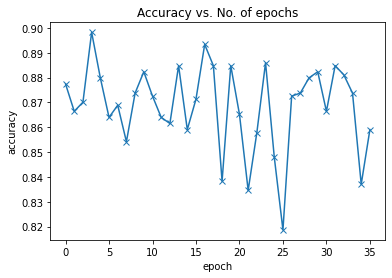

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

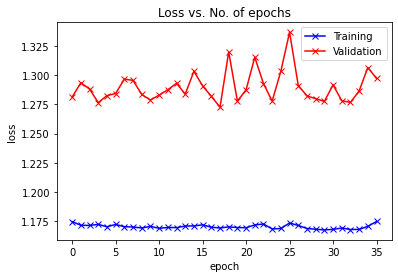

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [30]:
evaluate(model, val_dl)

{'val_loss': 1.2972148656845093, 'val_acc': 0.8590686321258545}

In [28]:
joblib.dump(model, 'rf_model.h5',protocol=4)

['rf_model.h5']

In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: livingroom , Predicted: livingroom


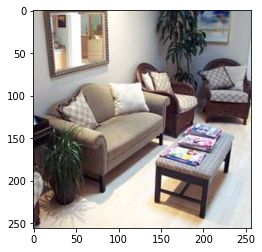

In [32]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: kitchen , Predicted: kitchen


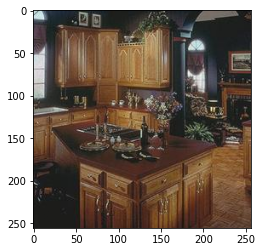

In [33]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bedroom , Predicted: bedroom


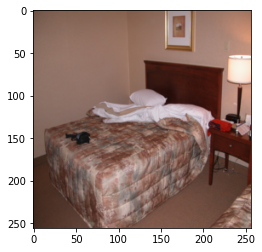

In [34]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [37]:
# predicting external Images:
import urllib.request 

urllib.request.urlretrieve("https://img2.baidu.com/it/u=2508342965,2066964244&fm=253&fmt=auto&app=138&f=JPEG?w=800&h=1066", "d.jpg")    



('d.jpg', <http.client.HTTPMessage at 0x7fd2e3b8c6a0>)

In [38]:
loaded_model = model

In [39]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles livingroom.


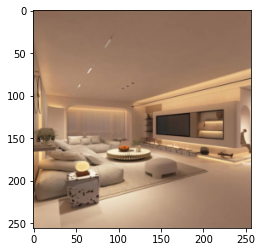

In [41]:
predict_external_image('d.jpg')